# Poisson Regression for Competiton

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from patsy import dmatrices
plt.style.use(['ggplot'])

In [2]:
# load the dataset
PATH = '/Users/dj/Documents/GitHub/Data/ts_forecast'
df = pd.read_csv( PATH + '/df.csv') # Training data 
df1 = pd.read_csv( PATH + '/df1.csv') # Testing data
df2 = pd.read_csv( PATH + '/df2.csv') # Complete data for Competition
reduced = pd.read_csv( PATH + '/reduced.csv') #Only last month
print(df.dtypes) # We can see that month is of type object, therefore it will be changed to datetime

Unnamed: 0     int64
d             object
date          object
weekday       object
id            object
sales          int64
dtype: object


In [3]:
# For some strange reason, a new column is being added which will be removed 
df = df.drop(['Unnamed: 0'], axis=1)
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)
reduced = reduced.drop(['Unnamed: 0'], axis=1)

In [4]:
# Change the type object of date to date
df['date'] = pd.to_datetime(df['date'])
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
reduced['date'] = pd.to_datetime(reduced['date'])

print(df.dtypes)

d                  object
date       datetime64[ns]
weekday            object
id                 object
sales               int64
dtype: object


In [5]:
df = df.sort_values(by = ['id', 'date'])
df1 = df1.sort_values(by = ['id', 'date'])
df2 = df2.sort_values(by = ['id', 'date'])
reduced = reduced.sort_values(by = ['id', 'date'])
df

,d,date,weekday,id,sales
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0
...,...,...,...,...,...
1570833,d_1909,2016-04-20,Wednesday,FOODS_3_827_TX_3_validation,0
1571482,d_1910,2016-04-21,Thursday,FOODS_3_827_TX_3_validation,1
1572453,d_1911,2016-04-22,Friday,FOODS_3_827_TX_3_validation,0
1573305,d_1912,2016-04-23,Saturday,FOODS_3_827_TX_3_validation,0


# End of Data Import - Let's do EDA

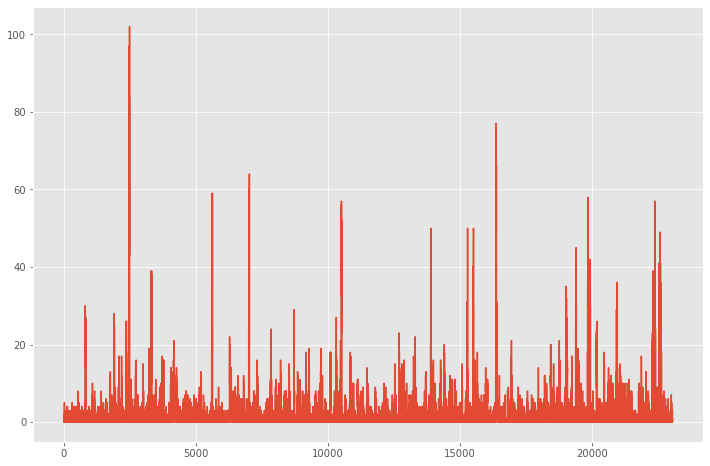

In [6]:
plt.figure(figsize=(12,8))
plt.plot(reduced["sales"])

# Creating a SMALL DATAFRAME frame for testing purposes 


In [6]:
names = np.unique(df['id'])
selected = names[0:1]

small_df = df[df['id'].isin(selected)]
small_df = small_df.sort_values(by = ['id', 'date'])

In [7]:
small_ds = small_df['date']
small_df['MONTH'] = small_ds.dt.month
small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
small_df['DAY'] = small_ds.dt.day

small_df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570915,d_1909,2016-04-20,Wednesday,FOODS_3_001_TX_3_validation,0,4,2,20
1571320,d_1910,2016-04-21,Thursday,FOODS_3_001_TX_3_validation,0,4,3,21
1572292,d_1911,2016-04-22,Friday,FOODS_3_001_TX_3_validation,5,4,4,22
1573265,d_1912,2016-04-23,Saturday,FOODS_3_001_TX_3_validation,2,4,5,23


In [34]:
piv_tab = small_df.pivot_table(index='date',columns='id',values='sales',aggfunc='sum')

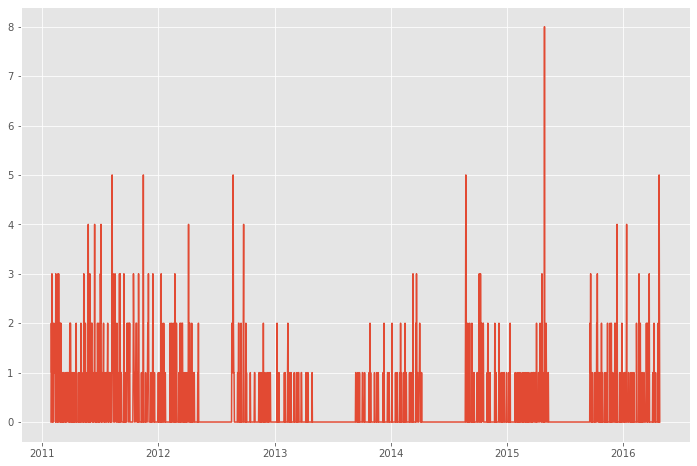

In [35]:
plt.figure(figsize=(12,8))
plt.plot(piv_tab)
plt.show()

# Transition to Poisson Regression

In [8]:
# Getting some additional data for the regression
ds = df['date']
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day


ds1 = df1['date']
df1['MONTH'] = ds.dt.month
df1['DAY_OF_WEEK'] = ds1.dt.dayofweek
df1['DAY'] = ds1.dt.day

ds2 = df2['date']
df2['MONTH'] = ds2.dt.month
df2['DAY_OF_WEEK'] = ds2.dt.dayofweek
df2['DAY'] = ds2.dt.day

rds = reduced['date']
reduced['MONTH'] = rds.dt.month
reduced['DAY_OF_WEEK'] = rds.dt.dayofweek
reduced['DAY'] = rds.dt.day

In [9]:
df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570833,d_1909,2016-04-20,Wednesday,FOODS_3_827_TX_3_validation,0,4,2,20
1571482,d_1910,2016-04-21,Thursday,FOODS_3_827_TX_3_validation,1,4,3,21
1572453,d_1911,2016-04-22,Friday,FOODS_3_827_TX_3_validation,0,4,4,22
1573305,d_1912,2016-04-23,Saturday,FOODS_3_827_TX_3_validation,0,4,5,23


# Poisson Regression 

In [10]:
# old way
mask = np.random.rand(len(small_df)) < 0.8
df_train = small_df[mask]
df_test = small_df[~mask]

# New way

#df_train = df
#df_test = df1
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=1521
Testing data set length=392


In [15]:
expr = """sales ~ DAY +  MONTH + weekday"""

In [16]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [17]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [18]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sales   No. Observations:                 1521
Model:                            GLM   Df Residuals:                     1512
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1186.6
Date:                Fri, 10 Dec 2021   Deviance:                       1580.3
Time:                        17:50:12   Pearson chi2:                 2.36e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03480
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0679 

In [43]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

             mean   mean_se  mean_ci_lower  mean_ci_upper
4698     0.358729  0.033514       0.298705       0.430814
5347     0.358760  0.032336       0.300664       0.428081
9275     0.358914  0.027457       0.308940       0.416972
18471    0.359254  0.026025       0.311701       0.414061
26086    0.353754  0.033376       0.294030       0.425609
...           ...       ...            ...            ...
1556389  0.348968  0.028519       0.297319       0.409589
1558905  0.349058  0.024710       0.303836       0.401010
1560488  0.349118  0.022489       0.307709       0.396099
1563413  0.349208  0.019850       0.312392       0.390363
1567670  0.349358  0.018150       0.315536       0.386806

[368 rows x 4 columns]


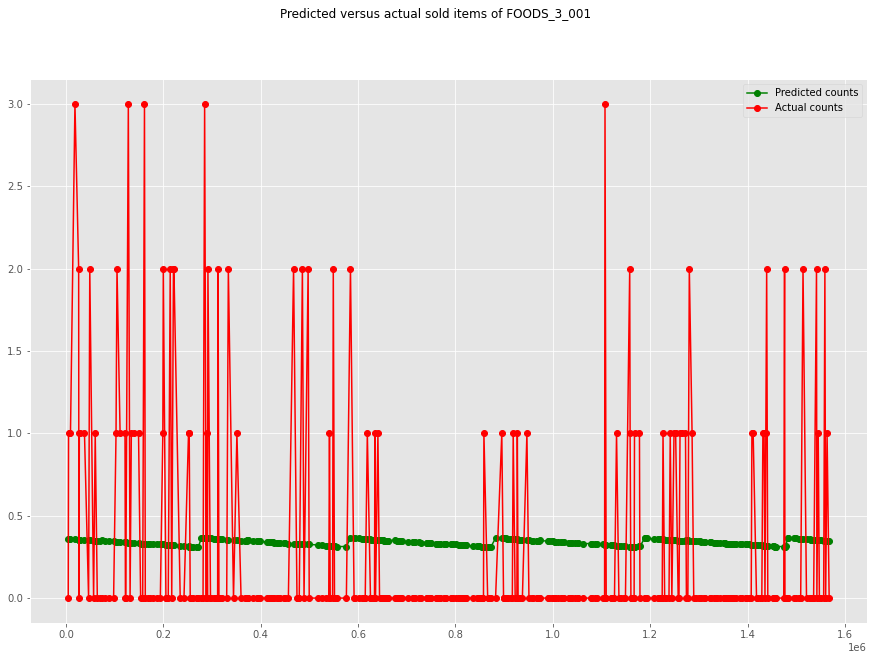

In [45]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['sales']
fig = plt.figure(figsize=(15,10))
fig.suptitle('Predicted versus actual sold items of FOODS_3_001')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


<Figure size 432x288 with 0 Axes>

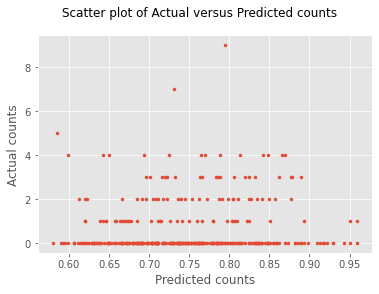

In [71]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [72]:
np.mean(y_test['sales'])

0.6328767123287671

# FOR LOOP FOR MULTIVARIATE FORECAST

In [297]:
names = np.unique(df['id'])

f = []
for i in np.arange(1,29):
    f.append('F' + str(i))

r = np.arange(28)

z = pd.Series(np.zeros(28))

d = {'mean': z}
forecasts = pd.DataFrame(d)

In [298]:
# get data ready
selected = names[0:5]
# zip_object = zip(selected, r)

for i in names:

    small_df = df[df['id'].isin([i])]
    small_df = small_df.sort_values(by = ['id', 'date'])

    small_r = reduced[reduced['id'].isin(selected)]
    small_r = small_r.sort_values(by = ['id', 'date'])

    small_ds = small_df['date']
    small_df['MONTH'] = small_ds.dt.month
    small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
    small_df['DAY'] = small_ds.dt.day

    small_dsr = small_r['date']
    small_r['MONTH'] = small_dsr.dt.month
    small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
    small_r['DAY'] = small_dsr.dt.day

    # Begin Regression
    expr = """sales ~ DAY +  MONTH + weekday"""

    y_train, X_train = dmatrices(expr, small_df, return_type='dataframe')
    y_test, X_test = dmatrices(expr, small_r, return_type='dataframe')

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    #summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    p = predictions_summary_frame['mean']
    forecasts[i] = p

/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/ipykernel_launcher.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [299]:
forecasts

,mean,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
0,0.0,0.300536,0.759305,0.162369,0.048995,0.744305,0.291222,4.158234,1.266469,0.174869,...,1.472963,1.101242,1.067333,0.155819,2.698823,0.143198,0.202251,0.677015,0.567105,0.359897
1,0.0,0.514026,0.627168,0.167178,0.093120,0.618908,0.308522,3.648683,0.838235,0.155437,...,1.450832,0.963848,1.073089,0.249284,2.482320,0.126709,0.226814,0.576109,0.641129,0.297736
2,0.0,0.177040,0.639500,0.156165,0.066568,0.544840,0.197820,3.172268,0.814628,0.173999,...,1.742986,0.804257,1.229471,0.319102,2.200918,0.142208,0.190488,0.468775,0.620160,0.352653
3,0.0,0.305351,0.530341,0.165870,0.062619,0.601631,0.265175,4.024489,0.864041,0.181167,...,1.083619,0.982195,1.056381,0.227216,2.413887,0.117147,0.218980,0.521788,0.607182,0.306763
4,0.0,0.334061,0.777787,0.117817,0.093032,0.793678,0.559057,5.508153,0.830658,0.248816,...,1.083745,1.475809,1.125453,0.313679,2.456728,0.268556,0.229073,0.635221,0.641478,0.377077
5,0.0,0.308699,0.945714,0.145424,0.146639,0.991349,0.478007,8.111117,0.860398,0.168932,...,1.545024,1.950871,1.448174,0.341514,3.352477,0.276620,0.308471,0.873682,0.734234,0.422423
6,0.0,0.436303,0.998832,0.210480,0.112784,0.943322,0.630317,6.929626,1.206326,0.192011,...,1.475880,1.874442,1.235752,0.482260,3.087020,0.328938,0.270679,0.881170,0.677009,0.527024
7,0.0,0.316078,1.000642,0.146017,0.067102,0.954043,0.548897,6.136095,1.192075,0.180685,...,1.515574,1.670888,1.118342,0.136501,2.519419,0.239400,0.191705,0.842432,0.571385,0.333017
8,0.0,0.540609,0.826506,0.150342,0.127536,0.793310,0.581506,5.384176,0.788997,0.160606,...,1.492803,1.462423,1.124373,0.218378,2.317309,0.211834,0.214987,0.716871,0.645967,0.275499
9,0.0,0.186195,0.842758,0.140438,0.091171,0.698371,0.372852,4.681155,0.766776,0.179786,...,1.793408,1.220280,1.288228,0.279540,2.054613,0.237745,0.180555,0.583312,0.624840,0.326315


In [300]:
forecasts = forecasts.drop(['mean'], axis=1)

In [301]:
# forecasts.set_index('F')

In [302]:
competition = forecasts.T

In [303]:
competition.columns = f

In [304]:
competition

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
FOODS_3_001_TX_3_validation,0.300536,0.514026,0.177040,0.305351,0.334061,0.308699,0.436303,0.316078,0.540609,0.186195,...,0.321756,0.297329,0.420232,0.304435,0.520695,0.179337,0.309312,0.315775,0.291801,0.412420
FOODS_3_002_TX_3_validation,0.759305,0.627168,0.639500,0.530341,0.777787,0.945714,0.998832,1.000642,0.826506,0.842758,...,0.655640,0.797195,0.841971,0.843497,0.696708,0.710408,0.589146,0.601960,0.731926,0.773036
FOODS_3_003_TX_3_validation,0.162369,0.167178,0.156165,0.165870,0.117817,0.145424,0.210480,0.146017,0.150342,0.140438,...,0.114672,0.141543,0.204861,0.142119,0.146329,0.136690,0.145184,0.113131,0.139641,0.202109
FOODS_3_004_TX_3_validation,0.048995,0.093120,0.066568,0.062619,0.093032,0.146639,0.112784,0.067102,0.127536,0.091171,...,0.076573,0.120697,0.092831,0.055231,0.104973,0.075041,0.070589,0.069470,0.109501,0.084220
FOODS_3_005_TX_3_validation,0.744305,0.618908,0.544840,0.601631,0.793678,0.991349,0.943322,0.954043,0.793310,0.698371,...,0.688152,0.859542,0.817900,0.827195,0.687833,0.605517,0.668632,0.640774,0.800363,0.761589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_TX_3_validation,0.143198,0.126709,0.142208,0.117147,0.268556,0.276620,0.328938,0.239400,0.211834,0.237745,...,0.200749,0.206777,0.245886,0.178955,0.158349,0.177718,0.146399,0.173566,0.178777,0.212590
FOODS_3_824_TX_3_validation,0.202251,0.226814,0.190488,0.218980,0.229073,0.308471,0.270679,0.191705,0.214987,0.180555,...,0.232713,0.313372,0.274980,0.194751,0.218403,0.183423,0.210859,0.234554,0.315852,0.277155
FOODS_3_825_TX_3_validation,0.677015,0.576109,0.468775,0.521788,0.635221,0.873682,0.881170,0.842432,0.716871,0.583312,...,0.551869,0.759039,0.765544,0.731890,0.622804,0.506771,0.564081,0.514388,0.707488,0.713552
FOODS_3_826_TX_3_validation,0.567105,0.641129,0.620160,0.607182,0.641478,0.734234,0.677009,0.571385,0.645967,0.624840,...,0.627214,0.717907,0.661955,0.558679,0.631603,0.610946,0.598160,0.620201,0.709881,0.654554


In [251]:
competition.to_csv(PATH + '/poisson_pred.csv', index=True)

In [158]:
selected = names[0:3]
zip_object = zip(selected, f)

for i,j in zip_object:
    print(i,j)

FOODS_3_001_TX_3_validation F1
FOODS_3_002_TX_3_validation F2
FOODS_3_003_TX_3_validation F3


# AML Math tutorial 

In [2]:
x = np.array([2,1,3,2,-1,0,1])

In [9]:
m = np.mean(x);m

s = []
for i in x:
    s.append(np.square((i - m)))

In [16]:
v = (np.sum(s) / (len(x)));v

1.5510204081632655

In [18]:
np.sqrt(v)

1.2453996981544782

In [2]:
w = np.array([2,3,1,2,-1,4,3])
x = np.array([1,2,1,3,2,1,3])

np.dot(w,x)

26

In [4]:
2+6+1+6-2+4+9

26